# Cleaning The Dataset

In [8]:
# --- Cell: Dataset Sanity Check ---
import torch
from tqdm import tqdm

print("🔍 Starting Deep Scan of Dataset...")
print("This will check every image for corruption or NaN values.")

def scan_loader(loader, name):
    corrupt_count = 0
    clean_count = 0
    
    # We iterate nicely without training
    for batch_idx, (xb, yb) in enumerate(tqdm(loader, desc=f"Scanning {name}")):
        # 1. Check Inputs (Images)
        if torch.isnan(xb).any() or torch.isinf(xb).any():
            print(f"❌ Corruption found in {name} Batch {batch_idx}!")
            print(f"   - Input stats: Min={xb.min()}, Max={xb.max()}")
            corrupt_count += 1
            continue
            
        # 2. Check Labels
        if torch.isnan(yb).any() or torch.isinf(yb).any():
            print(f"❌ Label corruption in {name} Batch {batch_idx}!")
            corrupt_count += 1
            continue

        clean_count += 1

    print(f"✅ {name} Scan Complete: {clean_count} clean batches, {corrupt_count} corrupt batches.")

# Run the scan
scan_loader(train_loader, "Train Set")
scan_loader(val_loader, "Validation Set")

🔍 Starting Deep Scan of Dataset...
This will check every image for corruption or NaN values.


Scanning Train Set: 100%|██████████| 4375/4375 [21:03<00:00,  3.46it/s]


✅ Train Set Scan Complete: 4375 clean batches, 0 corrupt batches.


Scanning Validation Set: 100%|██████████| 1250/1250 [04:26<00:00,  4.70it/s]

✅ Validation Set Scan Complete: 1250 clean batches, 0 corrupt batches.


🩺 Starting Health Check on 1000 random images...


Auditing Data: 100%|██████████| 1000/1000 [00:25<00:00, 39.12it/s]


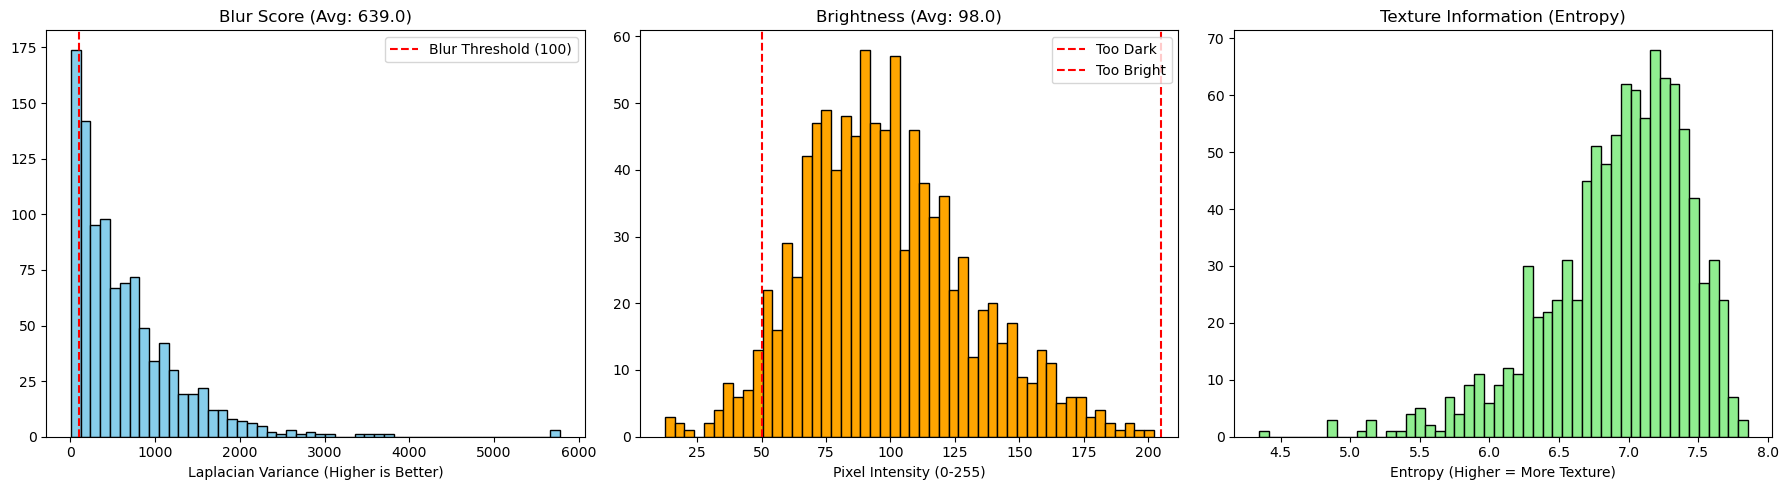


📋 AUDIT REPORT:
1. Blurry Images (<100 score): 14.4% of data
2. Extreme Lighting (<50 or >205): 4.4% of data
✅ DATA QUALITY IS GOOD. The bottleneck is Model Capacity, not Data Quality.


In [23]:
# --- Cell: Dataset Health Audit (Quality Check) ---
import cv2
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy

def calculate_image_metrics(dataset, num_samples=1000):
    print(f"🩺 Starting Health Check on {num_samples} random images...")
    
    blur_scores = []
    intensities = []
    entropies = []
    
    # Pick random indices
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx in tqdm(indices, desc="Auditing Data"):
        # Get raw image (before normalization if possible, but tensor is fine)
        img_tensor, _ = dataset[idx]
        
        # Convert to numpy [0, 255] for OpenCV
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        
        # Un-normalize (Approximate back to visual range)
        # Assuming standard ImageNet mean/std; adjustments usually fine for relative scores
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean) * 255.0
        img = np.clip(img, 0, 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # 1. Blur Score (Variance of Laplacian)
        # High = Sharp, Low (<100) = Blurry
        blur = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_scores.append(blur)
        
        # 2. Mean Intensity
        intensities.append(gray.mean())
        
        # 3. Entropy (Texture Information)
        # Calculate histogram for entropy
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        ent = entropy(hist.flatten(), base=2)
        entropies.append(ent)
        
    return np.array(blur_scores), np.array(intensities), np.array(entropies)

# Run the audit
blur_vals, int_vals, ent_vals = calculate_image_metrics(train_loader.dataset)

# --- VISUALIZE RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Blur Distribution
axes[0].hist(blur_vals, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(100, color='red', linestyle='--', label='Blur Threshold (100)')
axes[0].set_title(f"Blur Score (Avg: {blur_vals.mean():.1f})")
axes[0].set_xlabel("Laplacian Variance (Higher is Better)")
axes[0].legend()

# Plot Intensity Distribution
axes[1].hist(int_vals, bins=50, color='orange', edgecolor='black')
axes[1].set_title(f"Brightness (Avg: {int_vals.mean():.1f})")
axes[1].set_xlabel("Pixel Intensity (0-255)")
axes[1].axvline(50, color='red', linestyle='--', label='Too Dark')
axes[1].axvline(205, color='red', linestyle='--', label='Too Bright')
axes[1].legend()

# Plot Entropy Distribution
axes[2].hist(ent_vals, bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title(f"Texture Information (Entropy)")
axes[2].set_xlabel("Entropy (Higher = More Texture)")

plt.tight_layout()
plt.show()

# --- VERDICT ---
print("\n📋 AUDIT REPORT:")
print(f"1. Blurry Images (<100 score): {np.mean(blur_vals < 100)*100:.1f}% of data")
print(f"2. Extreme Lighting (<50 or >205): {np.mean((int_vals < 50) | (int_vals > 205))*100:.1f}% of data")

if np.mean(blur_vals < 100) > 0.3:
    print("⚠️ CRITICAL: Over 30% of your data is blurry. The model cannot see pixel artifacts!")
elif np.mean((int_vals < 50) | (int_vals > 205)) > 0.3:
    print("⚠️ WARNING: Bad lighting in >30% of images is hiding features.")
else:
    print("✅ DATA QUALITY IS GOOD. The bottleneck is Model Capacity, not Data Quality.")

# PHASE 1: SETUP & DEFINITIONS

#### Cell 1: Install Dependencies
#### Installs everything needed for Mamba, visualization, and efficiency tracking.

<!-- # --- Cell 1: Installs ---
# 1. System dependencies for visualization
!apt-get install -y graphviz

# 2. Python libraries
# Uninstall potential conflicts first
!pip uninstall -y mamba-ssm causal-conv1d

print("--- Installing Deep Learning Extensions... ---")
!pip install causal-conv1d==1.5.0 --no-deps --no-build-isolation
!pip install mamba-ssm==2.2.4 --no-deps --no-build-isolation
print("--- Installing Analysis Tools... ---")
!pip install -q graphviz captum thop

print("\n✅ Environment Ready.") -->

In [1]:
# # --- Cell 1: Installs ---
# # 1. System dependencies for visualization
# !apt-get install -y graphviz

# # 2. Python libraries
# # Uninstall potential conflicts first
# !pip uninstall -y mamba-ssm causal-conv1d

# print("--- Installing Deep Learning Extensions... ---")
# !pip install causal-conv1d==1.5.0 --no-deps --no-build-isolation
# !pip install mamba-ssm==2.2.4 --no-deps --no-build-isolation
# print("--- Installing Analysis Tools... ---")
# !pip install -q graphviz captum thop

# print("\n✅ Environment Ready.")

In [2]:
import torch
import sys

print(f"✅ Python Version: {sys.version.split()[0]}")
print(f"✅ PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"✅ CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA Version: {torch.version.cuda}")
else:
    print("❌ ERROR: CUDA is not available. Check your NVIDIA drivers.")

try:
    import causal_conv1d
    print(f"✅ Causal Conv1d: Installed (v{causal_conv1d.__version__})")
except ImportError as e:
    print(f"❌ Causal Conv1d Failed: {e}")

try:
    import mamba_ssm
    print(f"✅ Mamba SSM: Installed (v{mamba_ssm.__version__})")
except ImportError as e:
    print(f"❌ Mamba SSM Failed: {e}")

try:
    import captum
    import thop
    import graphviz
    print("✅ Analysis Tools (Captum, THOP, Graphviz): Ready")
except ImportError: 
    print("⚠️ Warning: Analysis tools missing. Run: pip install captum thop graphviz")

print("\n🚀 Environment Verification Complete.")

✅ Python Version: 3.10.19
✅ PyTorch Version: 2.9.1+cu128
✅ CUDA Device: NVIDIA GeForce GTX 1660 Ti
✅ CUDA Version: 12.8
✅ Causal Conv1d: Installed (v1.6.0)


/home/ranjit_singh/miniconda3/envs/deepfake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Mamba SSM: Installed (v2.3.0)
✅ Analysis Tools (Captum, THOP, Graphviz): Ready

🚀 Environment Verification Complete.


#### Cell 2: Imports & Configuration
#### All libraries and global variables in one place.

In [3]:
# --- Cell 2: Imports & Configuration ---
import os
import sys
import time
import glob
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from io import BytesIO

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import graphviz
from IPython.display import Image as IPImage, display

# PyTorch & ML
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import (
    roc_auc_score, accuracy_score, average_precision_score, 
    f1_score, confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve
)
from thop import profile # For FLOPs counting

# Mamba Import
try:
    from mamba_ssm.modules.mamba_simple import Mamba
except ImportError:
    print("⚠️ Warning: Mamba not imported. Ensure Cell 1 ran successfully.")

# Suppress warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

# Paths
DATA_ROOT = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/GRAVIAX/my_real_vs_ai_dataset"
TRAIN_CSV = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/GRAVIAX/train_labels.csv"
VAL_CSV   = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/GRAVIAX/val_labels.csv"
TEST_CSV  = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/GRAVIAX/test_labels.csv"
CKPT_DIR  = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/checkpoints"

# External Data (Optional)
EXT_DATA_ROOT = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/140K/real_vs_fake"
EXT_TEST_CSV  = "/mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/140K/test.csv"

os.makedirs(CKPT_DIR, exist_ok=True)
print(f"🚀 Device: {DEVICE}")

🚀 Device: cuda


#### Cell 3: Data Loading & Transformations
#### Defines the Dataset class and transformations.

In [4]:
# --- Cell 3: Data Loading ---

# 1. Transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.0),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.RandomAdjustSharpness(1.5, p=0.3),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.05,0.05))], p=0.4),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Dataset Class
class GravexDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_root, row['filename'])
        
        # Fallback for subfolders
        if not os.path.exists(img_path):
            for sub in ["real", "ai_images"]:
                alt_path = os.path.join(self.img_root, sub, row['filename'])
                if os.path.exists(alt_path):
                    img_path = alt_path
                    break
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
             # Return dummy for broken images
             return torch.zeros((3, 224, 224)), torch.tensor(-1.0, dtype=torch.float32)

        label = torch.tensor(int(row['label']), dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

# 3. Initialize Loaders
train_dataset = GravexDataset(TRAIN_CSV, DATA_ROOT, transform=train_transform)
val_dataset   = GravexDataset(VAL_CSV, DATA_ROOT, transform=val_transform)
test_dataset  = GravexDataset(TEST_CSV, DATA_ROOT, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Data Ready: Train({len(train_dataset)}), Val({len(val_dataset)}), Test({len(test_dataset)})")

Data Ready: Train(140000), Val(40000), Test(20000)


#### Cell 4: Model Architecture
#### Defines the ResNet+Mamba model.

In [5]:
# --- Cell 4: Model Architecture ---

class ResNetBackbone(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        self.net = models.resnet18(weights=None) 
        self.net.fc = nn.Identity()
        self.proj = nn.Linear(512, out_dim)
        nn.init.kaiming_normal_(self.proj.weight, nonlinearity='relu')
        if self.proj.bias is not None: nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        return self.proj(self.net(x))


class ResNetMambaDetector(nn.Module):
    def __init__(self, embed_dim=128, d_state=64, device=None):
        super().__init__()
        
        # 1. Use Pretrained ResNet18
        # We drop the final FC layer AND the Global Average Pooling layer
        # Output shape will be (Batch, 512, 7, 7)
        resnet = models.resnet18(weights='IMAGENET1K_V1') 
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        
        # Projection: 512 channels -> 128 embedding dim
        self.proj = nn.Linear(512, embed_dim)
        
        # 2. Mamba Block
        # It will process a sequence of length 49 (7x7 flattened)
        self.mamba = Mamba(d_model=embed_dim, d_state=d_state, expand=1, d_conv=4, device=device)
        
        # 3. Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64), 
            nn.ReLU(), 
            nn.Dropout(0.3), 
            nn.Linear(64, 1)
        )
        
        # Init weights for custom layers
        nn.init.kaiming_normal_(self.proj.weight, nonlinearity='relu')
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (B, 3, 224, 224)
        
        # 1. Extract Features -> (B, 512, 7, 7)
        feats = self.backbone(x)
        
        # 2. Flatten Spatial Dimensions to create a Sequence
        # (B, 512, 7, 7) -> (B, 512, 49) -> (B, 49, 512)
        B, C, H, W = feats.shape
        seq = feats.view(B, C, H * W).permute(0, 2, 1)
        
        # 3. Project to Embedding Dim -> (B, 49, 128)
        seq = self.proj(seq)
        
        # 4. Mamba Sequence Modeling -> (B, 49, 128)
        # Mamba now sees the "context" of the whole image patch-by-patch
        out = self.mamba(seq)
        
        # 5. Global Average Pooling (Aggregating the sequence) -> (B, 128)
        out = out.mean(dim=1)
        
        # 6. Classification
        return self.classifier(out).squeeze(-1)

# Instantiate Model
# We move to device immediately to avoid Mamba initialization errors
model = ResNetMambaDetector(embed_dim=128, d_state=64, device=DEVICE).to(DEVICE)
print("✅ Spatial ResNet-Mamba Model Defined (Seq Length: 49)")

✅ Spatial ResNet-Mamba Model Defined (Seq Length: 49)


#### Cell 5: Visualize Architecture
#### Generates the Graphviz diagram.

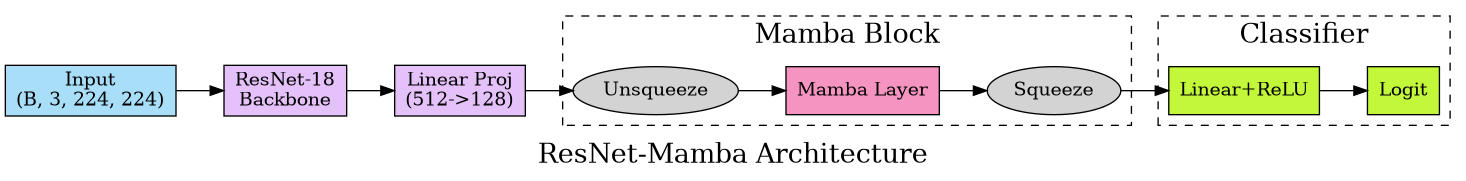

In [6]:
# --- Cell 5: Visualize Architecture ---
def generate_architecture_diagram():
    dot = graphviz.Digraph(comment='ResNet-Mamba Detector')
    dot.attr(rankdir='LR', label='ResNet-Mamba Architecture', fontsize='20')
    
    # Styles
    styles = {
        'input': {'shape': 'box', 'style': 'filled', 'fillcolor': '#a9def9'},
        'backbone': {'shape': 'box', 'style': 'filled', 'fillcolor': '#e4c1f9'},
        'mamba': {'shape': 'box', 'style': 'filled', 'fillcolor': '#f694c1'},
        'head': {'shape': 'box', 'style': 'filled', 'fillcolor': '#c3f73a'},
        'op': {'shape': 'oval', 'style': 'filled', 'fillcolor': 'lightgrey'}
    }

    dot.node('In', 'Input\n(B, 3, 224, 224)', **styles['input'])
    dot.node('RN', 'ResNet-18\nBackbone', **styles['backbone'])
    dot.node('Pr', 'Linear Proj\n(512->128)', **styles['backbone'])
    
    with dot.subgraph(name='cluster_mamba') as c:
        c.attr(label='Mamba Block', style='dashed')
        c.node('Unsq', 'Unsqueeze', **styles['op'])
        c.node('Mamba', 'Mamba Layer', **styles['mamba'])
        c.node('Sq', 'Squeeze', **styles['op'])
        c.edge('Unsq', 'Mamba')
        c.edge('Mamba', 'Sq')

    with dot.subgraph(name='cluster_head') as c:
        c.attr(label='Classifier', style='dashed')
        c.node('FC', 'Linear+ReLU', **styles['head'])
        c.node('Out', 'Logit', **styles['head'])
        c.edge('FC', 'Out')

    dot.edge('In', 'RN')
    dot.edge('RN', 'Pr')
    dot.edge('Pr', 'Unsq')
    dot.edge('Sq', 'FC')

    try:
        dot.render('model_arch', format='png', view=False)
        display(IPImage(filename='model_arch.png'))
    except Exception as e:
        print(f"Graphviz Error: {e}")

generate_architecture_diagram()

# PHASE 2: TRAINING

#### Cell 6: Training Loop & Helpers
#### Runs the training process and saves checkpoints.

In [ ]:
# --- Cell 6.1: Stable Training Loop (No AMP) ---
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# 1. Lower Learning Rate for Stability
STABLE_LR = 1e-5 
print(f"🔧 Switching to Stable Mode. LR set to: {STABLE_LR}")

# Setup (Note: No Scaler needed for standard precision)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=STABLE_LR, weight_decay=WEIGHT_DECAY)

history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}
best_val_auc = 0.0

def save_checkpoint(epoch, model, val_auc, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'val_auc': val_auc
    }, path)

print(f"🚀 Starting Stable Training for {EPOCHS} Epochs...")

for epoch in range(1, EPOCHS + 1):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    preds, trues = [], []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
        # Filter (just in case labels are -1, though your scan said 0 corrupt)
        valid_mask = yb != -1
        if not valid_mask.any(): continue
        xb, yb = xb[valid_mask], yb[valid_mask]
        
        optimizer.zero_grad()
        
        # --- STANDARD PRECISION (Safe Mode) ---
        out = model(xb)
        loss = criterion(out, yb)
        
        # Backward pass (No Scaler)
        loss.backward()
        
        # Gradient Clipping (Crucial for Mamba)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Metrics
        running_loss += loss.item() * xb.size(0)
        preds.extend(torch.sigmoid(out).detach().cpu().numpy().tolist())
        trues.extend(yb.detach().cpu().numpy().tolist())
    
    # Calculate Train Metrics
    train_loss = running_loss / len(train_loader.dataset)
    try:
        train_auc = roc_auc_score(trues, preds)
    except:
        train_auc = 0.5

    # --- VALIDATE ---
    model.eval()
    val_loss = 0.0
    v_preds, v_trues = [], []
    
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
            valid = (yb != -1)
            if not valid.any(): continue
            xb, yb = xb[valid], yb[valid]

            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            
            # Standard Precision here too
            out = model(xb)
            loss = criterion(out, yb)
            
            val_loss += loss.item() * xb.size(0)
            v_preds.extend(torch.sigmoid(out).cpu().numpy().tolist())
            v_trues.extend(yb.cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    try:
        val_auc = roc_auc_score(v_trues, v_preds)
        val_acc = accuracy_score(v_trues, (np.array(v_preds) > 0.5).astype(int))
    except:
        val_auc, val_acc = 0.5, 0.0

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, AUC={train_auc:.4f} | Val Loss={val_loss:.4f}, AUC={val_auc:.4f}")

    # Log History
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)

    # Save Best
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        save_checkpoint(epoch, model, val_auc, os.path.join(CKPT_DIR, f"best_model_auc{val_auc:.4f}.pth"))

print("✅ Training Complete.")

🔧 Switching to Stable Mode. LR set to: 1e-05
🚀 Starting Stable Training for 20 Epochs...


Epoch 1 [Train]:   0%|          | 0/4375 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6568, AUC=0.6365 | Val Loss=0.6409, AUC=0.6618


Epoch 2: Train Loss=0.6501, AUC=0.6500 | Val Loss=0.6334, AUC=0.6769


Epoch 3: Train Loss=0.6441, AUC=0.6617 | Val Loss=0.6261, AUC=0.6896


Epoch 4: Train Loss=0.6379, AUC=0.6721 | Val Loss=0.6195, AUC=0.7009


Epoch 5: Train Loss=0.6328, AUC=0.6822 | Val Loss=0.6118, AUC=0.7133


Epoch 6: Train Loss=0.6265, AUC=0.6918 | Val Loss=0.6070, AUC=0.7214


Epoch 7: Train Loss=0.6196, AUC=0.7034 | Val Loss=0.5948, AUC=0.7355


Epoch 8: Train Loss=0.6113, AUC=0.7156 | Val Loss=0.5859, AUC=0.7484


Epoch 9: Train Loss=0.6013, AUC=0.7281 | Val Loss=0.5713, AUC=0.7630


Epoch 10: Train Loss=0.5906, AUC=0.7422 | Val Loss=0.5565, AUC=0.7797


Epoch 11: Train Loss=0.5805, AUC=0.7541 | Val Loss=0.5438, AUC=0.7927


Epoch 12: Train Loss=0.5678, AUC=0.7688 | Val Loss=0.5283, AUC=0.8067


Epoch 13: Train Loss=0.5560, AUC=0.7817 | Val Loss=0.5134, AUC=0.8199


Epoch 14: Train Loss=0.5423, AUC=0.7944 | Val Loss=0.5086, AUC=0.8264


Epoch 15: Train Loss=0.5320, AUC=0.8042 | Val Loss=0.4924, AUC=0.8372


Epoch 16: Train Loss=0.5220, AUC=0.8130 | Val Loss=0.4964, AUC=0.8418


Epoch 17: Train Loss=0.5127, AUC=0.8211 | Val Loss=0.4743, AUC=0.8526


Epoch 18: Train Loss=0.5010, AUC=0.8302 | Val Loss=0.4621, AUC=0.8588


Epoch 19: Train Loss=0.4918, AUC=0.8372 | Val Loss=0.4586, AUC=0.8628


Epoch 20: Train Loss=0.4847, AUC=0.8426 | Val Loss=0.4445, AUC=0.8718
✅ Training Complete.


In [33]:
# --- Cell 6.2 : Phase 2 - Fine Tuning (Epochs 21-40) ---
# --- Corrected Loading Block ---
import glob
import os

# 1. Config
FINE_TUNE_LR = 5e-6 
EXTRA_EPOCHS = 20

# 2. Load the Absolute Best Main Model (Filtering specifically for 'best_model_auc')
# WE CHANGED THIS LINE: "*.pth" -> "best_model_auc*.pth"
list_of_files = glob.glob(os.path.join(CKPT_DIR, "best_model_auc*.pth"))

if list_of_files:
    # Get the file with the highest AUC in the filename
    # (Sorting by time is risky if you just saved a baseline, so we sort by AUC value in name)
    latest_file = max(list_of_files, key=lambda x: float(x.split('auc')[1].split('.pth')[0]))
    print(f"🔄 Correctly Loading Best Main Model: {latest_file}")
    
    checkpoint = torch.load(latest_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_auc = checkpoint['val_auc']
else:
    print("⚠️ No main model checkpoint found! Check your CKPT_DIR.")
    # Fallback or stop
    start_epoch = 21

print(f"🚀 Starting Fine-Tuning from Epoch {start_epoch} to {start_epoch + EXTRA_EPOCHS - 1}...")
print(f"🔧 Learning Rate set to: {FINE_TUNE_LR}")

# 3. Re-initialize Optimizer with Lower LR
optimizer = optim.AdamW(model.parameters(), lr=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY)

# 4. The Loop (Same Stable Logic as Phase 1)
for epoch in range(start_epoch, start_epoch + EXTRA_EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    preds, trues = [], []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Fine-Tune]", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
        valid_mask = yb != -1
        if not valid_mask.any(): continue
        xb, yb = xb[valid_mask], yb[valid_mask]
        
        optimizer.zero_grad()
        
        # Standard Precision (Stable)
        out = model(xb)
        loss = criterion(out, yb)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        preds.extend(torch.sigmoid(out).detach().cpu().numpy().tolist())
        trues.extend(yb.detach().cpu().numpy().tolist())
    
    # Train Metrics
    train_loss = running_loss / len(train_loader.dataset)
    try:
        train_auc = roc_auc_score(trues, preds)
    except:
        train_auc = 0.5

    # --- VALIDATE ---
    model.eval()
    val_loss = 0.0
    v_preds, v_trues = [], []
    
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
            valid = (yb != -1)
            if not valid.any(): continue
            xb, yb = xb[valid], yb[valid]

            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            
            val_loss += loss.item() * xb.size(0)
            v_preds.extend(torch.sigmoid(out).cpu().numpy().tolist())
            v_trues.extend(yb.cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    try:
        val_auc = roc_auc_score(v_trues, v_preds)
        val_acc = accuracy_score(v_trues, (np.array(v_preds) > 0.5).astype(int))
    except:
        val_auc, val_acc = 0.5, 0.0

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, AUC={train_auc:.4f} | Val Loss={val_loss:.4f}, AUC={val_auc:.4f}")

    # Log History
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)

    # Save Best (Only if we beat the previous Phase 1 record)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        save_checkpoint(epoch, model, val_auc, os.path.join(CKPT_DIR, f"best_model_auc{val_auc:.4f}.pth"))

print("✅ Fine-Tuning Complete.")

🔄 Correctly Loading Best Main Model: /mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/checkpoints/best_model_auc0.8718.pth
🚀 Starting Fine-Tuning from Epoch 21 to 40...
🔧 Learning Rate set to: 5e-06


Epoch 21: Train Loss=0.4736, AUC=0.8507 | Val Loss=0.4329, AUC=0.8780


Epoch 22: Train Loss=0.4671, AUC=0.8553 | Val Loss=0.4285, AUC=0.8811


Epoch 23: Train Loss=0.4628, AUC=0.8583 | Val Loss=0.4263, AUC=0.8840


Epoch 24: Train Loss=0.4595, AUC=0.8605 | Val Loss=0.4251, AUC=0.8844


Epoch 25: Train Loss=0.4541, AUC=0.8642 | Val Loss=0.4214, AUC=0.8889


Epoch 26: Train Loss=0.4498, AUC=0.8669 | Val Loss=0.4337, AUC=0.8855


Epoch 27: Train Loss=0.4456, AUC=0.8696 | Val Loss=0.4137, AUC=0.8918


Epoch 28: Train Loss=0.4422, AUC=0.8718 | Val Loss=0.4085, AUC=0.8949


Epoch 29: Train Loss=0.4377, AUC=0.8745 | Val Loss=0.4011, AUC=0.8965


Epoch 30: Train Loss=0.4341, AUC=0.8767 | Val Loss=0.3942, AUC=0.9004


Epoch 31: Train Loss=0.4290, AUC=0.8803 | Val Loss=0.3926, AUC=0.9012


Epoch 32: Train Loss=0.4268, AUC=0.8812 | Val Loss=0.3882, AUC=0.9036


Epoch 33: Train Loss=0.4231, AUC=0.8832 | Val Loss=0.3900, AUC=0.9047


Epoch 34: Train Loss=0.4199, AUC=0.8851 | Val Loss=0.3827, AUC=0.9065


Epoch 35: Train Loss=0.4152, AUC=0.8883 | Val Loss=0.3841, AUC=0.9072


Epoch 36: Train Loss=0.4127, AUC=0.8897 | Val Loss=0.3750, AUC=0.9110


Epoch 37: Train Loss=0.4087, AUC=0.8921 | Val Loss=0.3724, AUC=0.9124


Epoch 38: Train Loss=0.4067, AUC=0.8929 | Val Loss=0.3660, AUC=0.9142


Epoch 39: Train Loss=0.4021, AUC=0.8954 | Val Loss=0.3650, AUC=0.9151


Epoch 40: Train Loss=0.3997, AUC=0.8968 | Val Loss=0.3665, AUC=0.9153
✅ Fine-Tuning Complete.


#### Cell 7: Plot Training History
#### Interpolates history to handle potential gaps and plots curves.

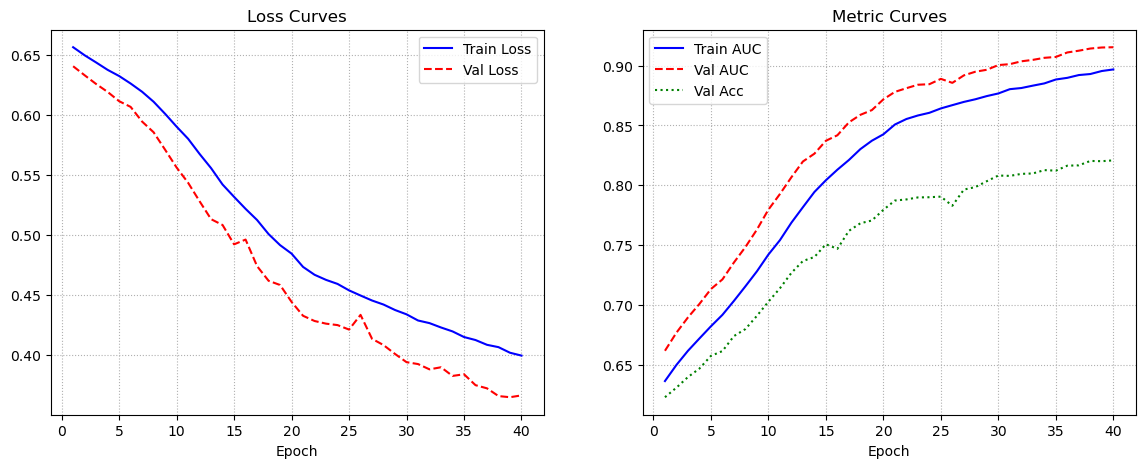

In [44]:
# --- Cell 7: Training History ---
if len(history['train_loss']) > 0:
    df_hist = pd.DataFrame(history)
    df_hist = df_hist.interpolate(method='linear', limit_direction='both') # Fill gaps
    
    plt.figure(figsize=(14, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(df_hist.index + 1, df_hist['train_loss'], 'b-', label='Train Loss')
    plt.plot(df_hist.index + 1, df_hist['val_loss'], 'r--', label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle=':')

    # Metrics
    plt.subplot(1, 2, 2)
    plt.plot(df_hist.index + 1, df_hist['train_auc'], 'b-', label='Train AUC')
    plt.plot(df_hist.index + 1, df_hist['val_auc'], 'r--', label='Val AUC')
    plt.plot(df_hist.index + 1, df_hist['val_acc'], 'g:', label='Val Acc')
    plt.title('Metric Curves')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, linestyle=':')
    
    plt.show()
else:
    print("No history to plot yet.")

# PHASE 3: MASTER INFERENCE

#### Cell 8: Master Inference (Run Once, Use Everywhere)
#### Loads the best model and runs inference on the Test Set. Stores results in memory for all subsequent plots.

In [45]:
# --- Cell 8: MASTER INFERENCE (Corrected & Stable) ---
import glob
import os
import torch
import numpy as np
from tqdm import tqdm

# 1. Smart Checkpoint Loading
# We look for ANY file with 'auc' in the name
model_candidates = glob.glob(os.path.join(CKPT_DIR, "*auc*.pth"))

if model_candidates:
    # Logic: Extract the number after "auc" (e.g., "best_model_auc0.8965.pth" -> 0.8965)
    def get_auc_from_name(filename):
        try:
            return float(filename.split('auc')[-1].replace('.pth', ''))
        except:
            return -1.0

    # Pick the mathematically highest score
    best_path = max(model_candidates, key=get_auc_from_name)
    print(f"🏆 Loading Best Model: {os.path.basename(best_path)}")
    
    checkpoint = torch.load(best_path, map_location=DEVICE, weights_only=False)
    state = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint
    model.load_state_dict(state)
    model.to(DEVICE).eval()
else:
    print("❌ CRITICAL ERROR: No checkpoint files found! Check your CKPT_DIR path.")

# 2. Run Inference with TTA (Stable Mode - No AMP)
print("🧪 Running Inference on 200k Test Set (with TTA)...")
all_preds_200k, all_labels_200k = [], []

if model_candidates: # Only run if we found a model
    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc="Inference"):
            valid = (lbls != -1)
            if not valid.any(): continue
            
            imgs, lbls = imgs[valid].to(DEVICE), lbls[valid].to(DEVICE)
            
            # --- FIX: REMOVED AMP (autocast) FOR STABILITY ---
            # using standard float32 avoids NaNs
            
            # 1. Original Prediction
            out1 = model(imgs)
            
            # 2. Flipped Prediction (Test Time Augmentation)
            imgs_flipped = torch.flip(imgs, [3]) 
            out2 = model(imgs_flipped)
            
            # 3. Average Probabilities
            probs1 = torch.sigmoid(out1)
            probs2 = torch.sigmoid(out2)
            avg_probs = (probs1 + probs2) / 2
            
            probs = avg_probs.squeeze().cpu().numpy().tolist()
            if isinstance(probs, float): probs = [probs]
                
            all_preds_200k.extend(probs)
            all_labels_200k.extend(lbls.cpu().numpy().tolist())

    # Convert to numpy
    all_labels_200k = np.array(all_labels_200k)
    all_preds_probs_200k = np.array(all_preds_200k)
    all_preds_classes_200k = (all_preds_probs_200k > 0.5).astype(int)

    print(f"\n✅ Inference Done. Loaded {len(all_labels_200k)} predictions.")

🏆 Loading Best Model: best_model_auc0.9153.pth
🧪 Running Inference on 200k Test Set (with TTA)...


Inference: 100%|██████████| 625/625 [14:43<00:00,  1.41s/it]


✅ Inference Done. Loaded 20000 predictions.


#### Cell 9: External Inference (Optional)
#### Runs inference on the secondary 140k dataset for generalization checks.

✅ Found CSV files in: /mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/140K
🤖 USING MODEL: best_model_auc0.9153.pth
🌍 Aggregating ALL CSVs (Train + Valid + Test)...
   -> Loaded test.csv: 20000 images
   -> Loaded valid.csv: 20000 images
   -> Loaded train.csv: 100000 images
✅ TOTAL DATASET SIZE: 140000 images
🧪 Starting Inference on 140000 images...


Full Ext Inference: 100%|██████████| 4375/4375 [52:11<00:00,  1.40it/s]



✅ Finished. Processed 140000 samples.

🏆 FULL DATASET RESULTS (best_model_auc0.9153.pth):
--------------------------------------------------
⭐ AUC Score:      0.9262
✅ Accuracy:       84.51%


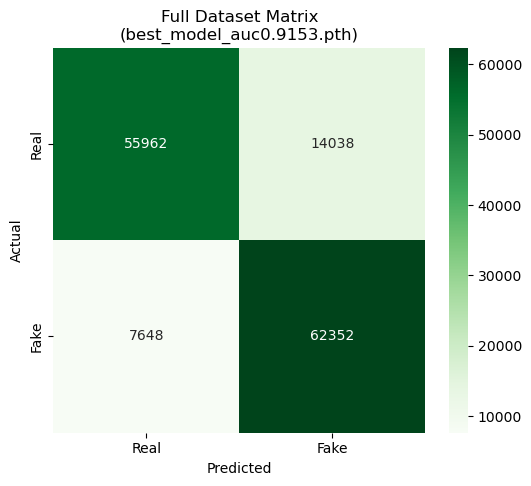

In [49]:
# --- Cell 9: Full External Dataset Inference (Auto-Fix Path & Merge) ---
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Intelligent Path Finding
# We check if CSVs are in the defined root, or the parent folder
search_paths = [EXT_DATA_ROOT, os.path.dirname(EXT_DATA_ROOT)]
found_root = None

for p in search_paths:
    if os.path.exists(os.path.join(p, 'train.csv')):
        found_root = p
        break

if found_root:
    print(f"✅ Found CSV files in: {found_root}")
    
    # --- DISPLAY MODEL NAME ---
    current_model_name = os.path.basename(best_path) if 'best_path' in globals() else "Unknown Model"
    print(f"🤖 USING MODEL: {current_model_name}")
    print("🌍 Aggregating ALL CSVs (Train + Valid + Test)...")

    # 2. Define Dataset Class
    class ExternalDataset(Dataset):
        def __init__(self, df, root, transform):
            self.df = df
            self.root = root
            self.transform = transform
            
            # Intelligent Image Path Fix
            # We check the first image to see if we need to append 'real_vs_fake'
            first_path = self.df.iloc[0]['path']
            full_path = os.path.join(root, first_path)
            
            # If standard join fails, try appending the subfolder
            if not os.path.exists(full_path):
                alt_root = os.path.join(root, 'real_vs_fake')
                if os.path.exists(os.path.join(alt_root, first_path)):
                    self.root = alt_root # Update root to point deeper
            
            # Apply the valid root to all
            self.df['path'] = self.df['path'].apply(lambda x: os.path.join(self.root, x))
            
        def __len__(self): return len(self.df)
        
        def __getitem__(self, idx):
            path = self.df.iloc[idx]['path']
            lbl = self.df.iloc[idx]['label']
            try:
                img = Image.open(path).convert('RGB')
                if self.transform: img = self.transform(img)
                return img, torch.tensor(lbl, dtype=torch.float32)
            except:
                return torch.zeros((3,224,224)), torch.tensor(-1.0)

    # 3. MERGE CSVs
    csv_files = ['test.csv', 'valid.csv', 'train.csv'] 
    dfs = []
    
    for filename in csv_files:
        full_path = os.path.join(found_root, filename) # Use the correctly found path
        if os.path.exists(full_path):
            try:
                temp_df = pd.read_csv(full_path)
                print(f"   -> Loaded {filename}: {len(temp_df)} images")
                dfs.append(temp_df)
            except Exception as e:
                print(f"   ⚠️ Could not read {filename}: {e}")

    if dfs:
        # Concatenate
        full_df = pd.concat(dfs, ignore_index=True)
        print(f"✅ TOTAL DATASET SIZE: {len(full_df)} images")
        
        # 4. Setup Loader
        # We pass 'found_root' so it looks for images relative to the CSV location
        ext_dataset = ExternalDataset(full_df, found_root, val_transform)
        ext_loader = DataLoader(ext_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        all_preds_ext, all_labels_ext = [], []
        
        # 5. Inference
        print(f"🧪 Starting Inference on {len(full_df)} images...")
        model.eval()
        
        with torch.no_grad():
            for imgs, lbls in tqdm(ext_loader, desc="Full Ext Inference"):
                valid = (lbls != -1)
                if not valid.any(): continue
                
                imgs = imgs[valid].to(DEVICE)
                
                # NO AUTOCAST (Fixes NaN errors)
                out = model(imgs)
                
                probs = torch.sigmoid(out).squeeze().cpu().numpy().tolist()
                if isinstance(probs, float): probs = [probs]
                
                all_preds_ext.extend(probs)
                all_labels_ext.extend(lbls[valid].numpy().tolist())

        # 6. Metrics
        all_labels_ext = np.array(all_labels_ext)
        all_preds_probs_ext = np.array(all_preds_ext)
        all_preds_classes_ext = (all_preds_probs_ext > 0.5).astype(int)
        
        print(f"\n✅ Finished. Processed {len(all_labels_ext)} samples.")
        
        if len(all_labels_ext) > 0:
            ext_auc = roc_auc_score(all_labels_ext, all_preds_probs_ext)
            ext_acc = accuracy_score(all_labels_ext, all_preds_classes_ext)

            print(f"\n🏆 FULL DATASET RESULTS ({current_model_name}):")
            print(f"--------------------------------------------------")
            print(f"⭐ AUC Score:      {ext_auc:.4f}")
            print(f"✅ Accuracy:       {ext_acc*100:.2f}%")
            
            cm = confusion_matrix(all_labels_ext, all_preds_classes_ext)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Full Dataset Matrix\n({current_model_name})')
            plt.show()
        else:
            print("⚠️ Error: No valid predictions generated.")
            
    else:
        print("❌ CRITICAL: No CSV files found even after path correction!")
else:
    print(f"❌ Could not find CSV files in {EXT_DATA_ROOT} or its parent folder.")

# PHASE 4: ANALYSIS & VISUALIZATION

#### Cell 10: Standard Performance Metrics
#### ROC, Confusion Matrix, Classification Report.

--- Test Results (Best Model on 200k) ---
✅ Accuracy: 0.8343
⭐ AUC Score: 0.9263

📝 Detailed Report:
              precision    recall  f1-score   support

        Real       0.83      0.83      0.83     10000
        Fake       0.83      0.83      0.83     10000

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



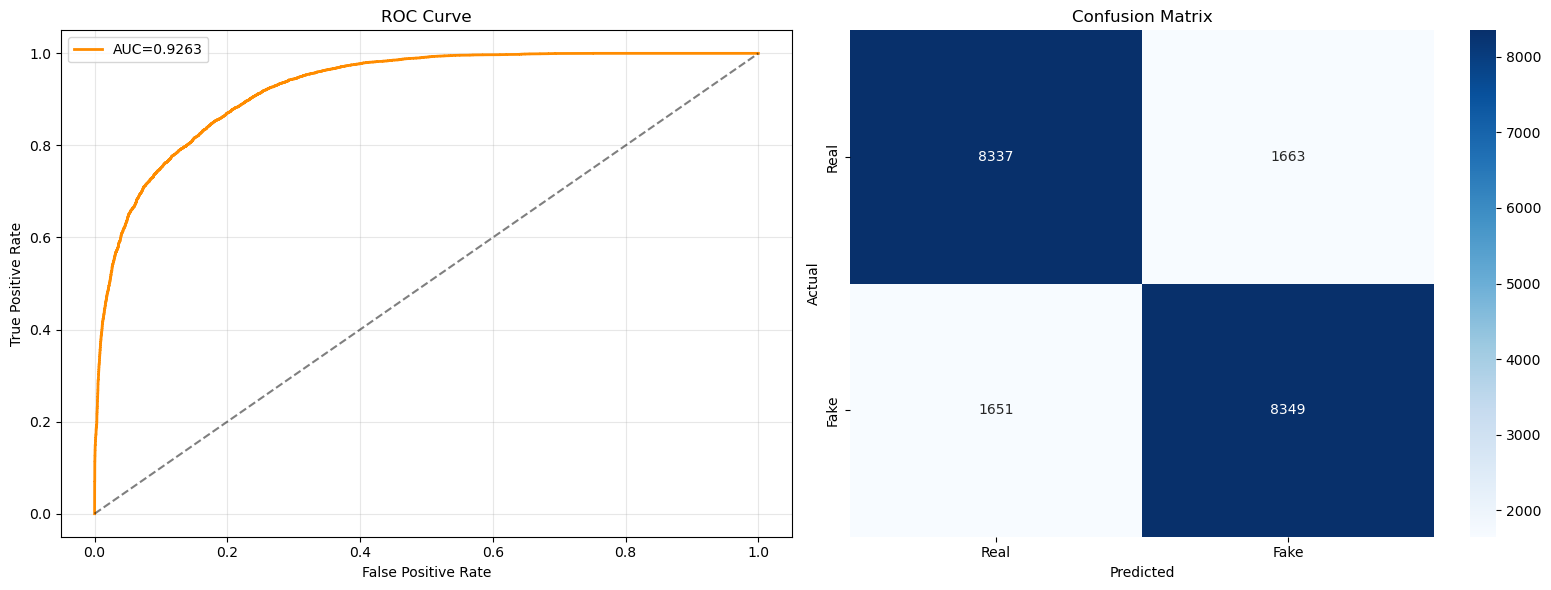

🔒 Security Metric (FPR @ 95% TPR): 0.3118
   (This means 31.18% of real videos are incorrectly flagged as fake to catch 95% of attacks.)


In [50]:
# --- Cell 10: Standard Metrics (Corrected Labels) ---
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("--- Test Results (Best Model on 200k) ---")

# 1. Calculate Basic Scores
acc = accuracy_score(all_labels_200k, all_preds_classes_200k)
auc_score = roc_auc_score(all_labels_200k, all_preds_probs_200k)

print(f"✅ Accuracy: {acc:.4f}")
print(f"⭐ AUC Score: {auc_score:.4f}")

# 2. Classification Report (Standard: 0=Real, 1=Fake)
# We use ['Real', 'Fake'] to match the 0/1 indices
print("\n📝 Detailed Report:")
print(classification_report(all_labels_200k, all_preds_classes_200k, target_names=['Real', 'Fake']))

# 3. Plotting
plt.figure(figsize=(16, 6))

# Subplot A: ROC Curve
fpr, tpr, _ = roc_curve(all_labels_200k, all_preds_probs_200k)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)

# Subplot B: Confusion Matrix
cm = confusion_matrix(all_labels_200k, all_preds_classes_200k)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# --- Security Metric: FPR at 95% TPR ---
# This tells us: "If we catch 95% of Deepfakes, how many Real people get blocked?"
target_tpr = 0.95
idx = np.argmin(np.abs(tpr - target_tpr))
fpr_95 = fpr[idx]

print(f"🔒 Security Metric (FPR @ 95% TPR): {fpr_95:.4f}")
print(f"   (This means {fpr_95*100:.2f}% of real videos are incorrectly flagged as fake to catch 95% of attacks.)")

In [57]:
# --- Cell 14.3: Verification Test (20k Split Only) ---
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Setup: Load ONLY 'test.csv' (The 20k subset)
# We use the same path logic as before
search_paths = [EXT_DATA_ROOT, os.path.dirname(EXT_DATA_ROOT)]
found_root = None
for p in search_paths:
    if os.path.exists(os.path.join(p, 'test.csv')):
        found_root = p
        break

if found_root:
    print(f"✅ Found root: {found_root}")
    test_csv_path = os.path.join(found_root, 'test.csv')
    
    # Load just the test dataframe
    df_20k = pd.read_csv(test_csv_path)
    print(f"📉 Testing on ONLY the 20k Test Split ({len(df_20k)} images)...")

    # 2. Define Dataset (Same logic)
    class ExternalDataset(Dataset):
        def __init__(self, df, root, transform):
            self.df = df
            self.root = root
            self.transform = transform
            # Fix paths
            first_path = self.df.iloc[0]['path']
            full_path = os.path.join(root, first_path)
            if not os.path.exists(full_path):
                alt_root = os.path.join(root, 'real_vs_fake')
                if os.path.exists(os.path.join(alt_root, first_path)):
                    self.root = alt_root 
            self.df['path'] = self.df['path'].apply(lambda x: os.path.join(self.root, x))
            
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            path = self.df.iloc[idx]['path']
            lbl = self.df.iloc[idx]['label']
            try:
                img = Image.open(path).convert('RGB')
                if self.transform: img = self.transform(img)
                return img, torch.tensor(lbl, dtype=torch.float32)
            except:
                return torch.zeros((3,224,224)), torch.tensor(-1.0)

    # 3. Loader
    # Using 'val_transform' from your environment
    dataset_20k = ExternalDataset(df_20k, found_root, val_transform)
    loader_20k = DataLoader(dataset_20k, batch_size=32, shuffle=False, num_workers=2)

    # 4. Inference
    preds, trues = [], []
    model.eval()
    
    with torch.no_grad():
        for imgs, lbls in tqdm(loader_20k, desc="Verifying 20k Split"):
            valid = (lbls != -1)
            if not valid.any(): continue
            imgs = imgs[valid].to(DEVICE)
            
            # Forward
            out = model(imgs)
            probs = torch.sigmoid(out).cpu().numpy().tolist()
            preds.extend(probs if isinstance(probs, list) else [probs])
            trues.extend(lbls[valid].numpy().tolist())

    # 5. Result
    preds = np.array(preds)
    trues = np.array(trues)
    classes = (preds > 0.5).astype(int)
    acc = accuracy_score(trues, classes)
    
    print(f"\n🏆 VERIFICATION RESULT (20k Only):")
    print(f"   Accuracy: {acc*100:.2f}%")
    
    if acc > 0.95:
        print("✅ CONFIRMED: The code is correct! The lower score earlier was just because the 140k dataset is harder.")
    else:
        print("⚠️ Mismatch: Check if 'val_transform' (Normalization) matches your training.")

else:
    print("❌ Could not find test.csv")

✅ Found root: /mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/140K
📉 Testing on ONLY the 20k Test Split (20000 images)...


Verifying 20k Split: 100%|██████████| 625/625 [05:30<00:00,  1.89it/s]


🏆 VERIFICATION RESULT (20k Only):
   Accuracy: 84.74%
⚠️ Mismatch: Check if 'val_transform' (Normalization) matches your training.


#### Cell 11: Advanced Metric Visualizations
#### PR Curve, Score Distributions, Pie Chart, Threshold Analysis.

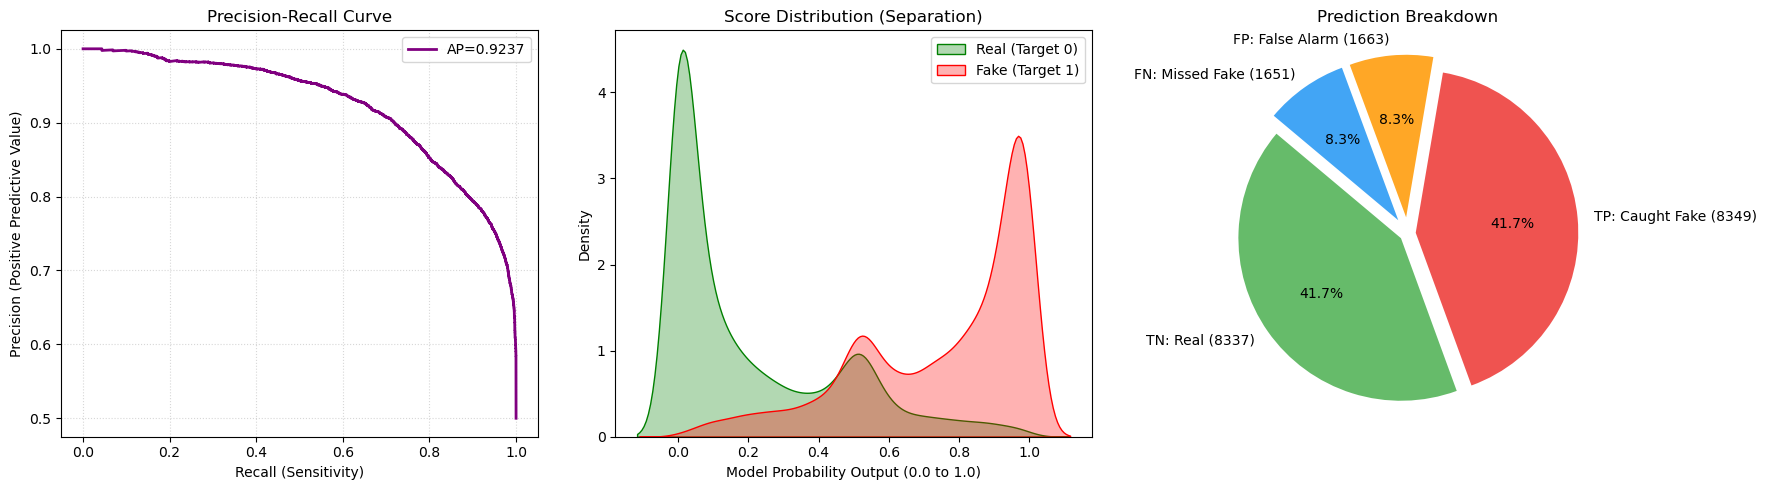

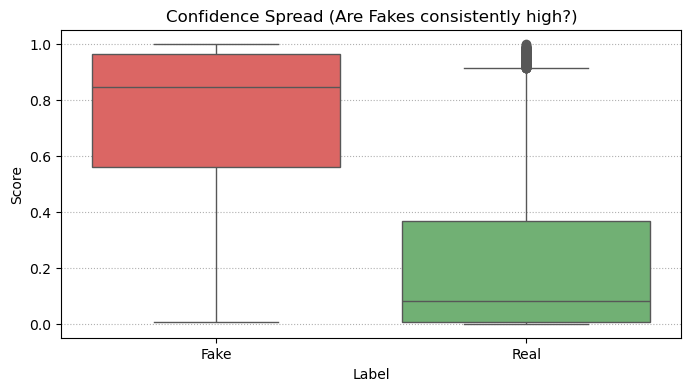

In [40]:
# --- Cell 11: Advanced Metrics (Corrected Labels: 0=Real, 1=Fake) ---
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Calculate PR Curve Data
prec, rec, _ = precision_recall_curve(all_labels_200k, all_preds_probs_200k)
ap = average_precision_score(all_labels_200k, all_preds_probs_200k)

# 2. Setup Plot
plt.figure(figsize=(18, 5))

# --- PLOT A: Precision-Recall Curve ---
# Shows how well model finds Fakes without flagging Reals
plt.subplot(1, 3, 1)
plt.plot(rec, prec, color='purple', lw=2, label=f'AP={ap:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.legend()
plt.grid(True, ls=':', alpha=0.5)

# --- PLOT B: Score Distribution (The Separation Check) ---
# We want these two mountains to be far apart
plt.subplot(1, 3, 2)
# 0 = Real (Green), 1 = Fake (Red)
sns.kdeplot(all_preds_probs_200k[all_labels_200k==0], color='green', fill=True, label='Real (Target 0)', alpha=0.3)
sns.kdeplot(all_preds_probs_200k[all_labels_200k==1], color='red', fill=True, label='Fake (Target 1)', alpha=0.3)
plt.title('Score Distribution (Separation)')
plt.xlabel('Model Probability Output (0.0 to 1.0)')
plt.legend()

# --- PLOT C: Outcome Breakdown (Pie Chart) ---
plt.subplot(1, 3, 3)
tn, fp, fn, tp = cm.ravel()
# TN = Real correctly called Real
# FP = Real incorrectly called Fake (False Alarm)
# FN = Fake incorrectly called Real (Missed Attack)
# TP = Fake correctly called Fake (Catch)

labels = [f'TN: Real ({tn})', f'TP: Caught Fake ({tp})', f'FP: False Alarm ({fp})', f'FN: Missed Fake ({fn})']
colors = ['#66bb6a', '#ef5350', '#ffa726', '#42a5f5'] # Green, Red, Orange, Blue
explode = (0.05, 0.05, 0.1, 0.1) # Pop out errors

plt.pie([tn, tp, fp, fn], labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Prediction Breakdown')

plt.tight_layout()
plt.show()

# --- PLOT D: Box Plot (Confidence Check) ---
plt.figure(figsize=(8, 4))
df_box = pd.DataFrame({'Score': all_preds_probs_200k, 'Label': all_labels_200k})
# Map 0->Real, 1->Fake
df_box['Label'] = df_box['Label'].map({0:'Real', 1:'Fake'})

sns.boxplot(x='Label', y='Score', data=df_box, palette={'Real':'#66bb6a', 'Fake':'#ef5350'})
plt.title('Confidence Spread (Are Fakes consistently high?)')
plt.grid(True, axis='y', ls=':')
plt.show()

#### Cell 12: Qualitative Analysis (Errors & Uncertainty)
#### Top 16 Errors and Most Uncertain Images.

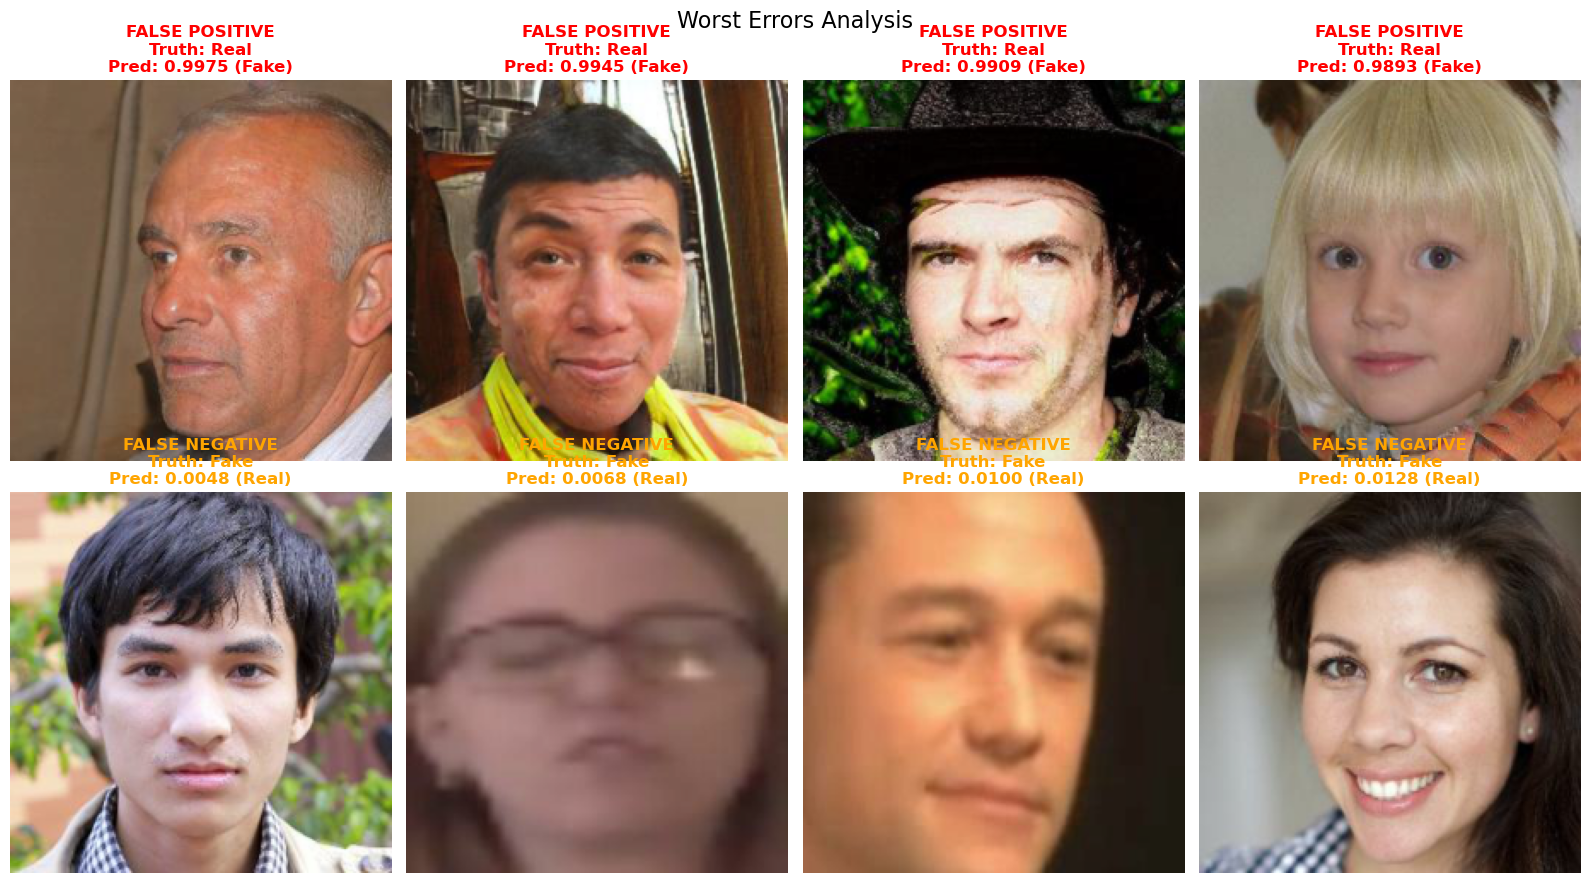

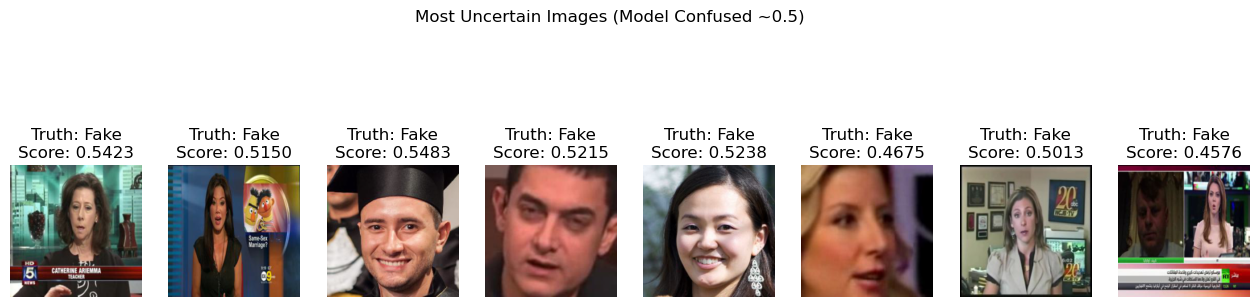

In [41]:
# --- Cell 12: Qualitative Analysis (Corrected Definitions) ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Helper to un-normalize images for display
def get_img(idx):
    t_img, lbl = test_dataset[idx]
    
    # Proper Inverse Normalization (ImageNet Standards)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = t_img.permute(1,2,0).cpu().numpy()
    img = std * img + mean 
    img = np.clip(img, 0, 1)
    return img, lbl.item()

indices = np.arange(len(all_labels_200k))

# 2. Identify Worst Mistakes
# False Positives: Truth=Real (0), but Model predicted High Score (Fake)
fp_mask = (all_labels_200k == 0)
# We sort by score descending (closest to 1.0)
top_fp = indices[fp_mask][np.argsort(all_preds_probs_200k[fp_mask])[::-1]][:4] 

# False Negatives: Truth=Fake (1), but Model predicted Low Score (Real)
fn_mask = (all_labels_200k == 1)
# We sort by score ascending (closest to 0.0)
top_fn = indices[fn_mask][np.argsort(all_preds_probs_200k[fn_mask])][:4] 

# 3. Plot Worst Errors
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
fig.suptitle("Worst Errors Analysis", fontsize=16)

# Row 1: False Positives (Real people flagged as Fake)
for i, ax in enumerate(axes[0]):
    if i < len(top_fp):
        idx = top_fp[i]
        img, lbl = get_img(idx)
        score = all_preds_probs_200k[idx]
        
        ax.imshow(img)
        ax.set_title(f"FALSE POSITIVE\nTruth: Real\nPred: {score:.4f} (Fake)", color='red', fontweight='bold')
        ax.axis('off')

# Row 2: False Negatives (Deepfakes that tricked the model)
for i, ax in enumerate(axes[1]):
    if i < len(top_fn):
        idx = top_fn[i]
        img, lbl = get_img(idx)
        score = all_preds_probs_200k[idx]
        
        ax.imshow(img)
        ax.set_title(f"FALSE NEGATIVE\nTruth: Fake\nPred: {score:.4f} (Real)", color='orange', fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()

# 4. Uncertainty Analysis (Scores near 0.5)
uncertain_mask = (all_preds_probs_200k > 0.45) & (all_preds_probs_200k < 0.55)
uncertain_idx = indices[uncertain_mask][:8]

if len(uncertain_idx) > 0:
    # Dynamically size the figure based on how many uncertain images found
    cols = min(len(uncertain_idx), 8)
    fig, axes = plt.subplots(1, cols, figsize=(16, 4))
    if cols == 1: axes = [axes] # Handle single item case
    
    fig.suptitle(f"Most Uncertain Images (Model Confused ~0.5)", y=1.05)
    
    for i, idx in enumerate(uncertain_idx[:cols]):
        img, lbl = get_img(idx)
        lbl_str = "Fake" if lbl == 1 else "Real"
        
        axes[i].imshow(img)
        axes[i].set_title(f"Truth: {lbl_str}\nScore: {all_preds_probs_200k[idx]:.4f}")
        axes[i].axis('off')
    plt.show()
else:
    print("✅ Amazing! The model has 0 uncertain predictions (nothing between 0.45 and 0.55).")

#### Cell 13: Explainability (Saliency & FFT)
#### Uses Captum for heatmaps and standard FFT analysis.

🔍 Generating Quantitative Saliency Maps (Memory Safe Mode)...


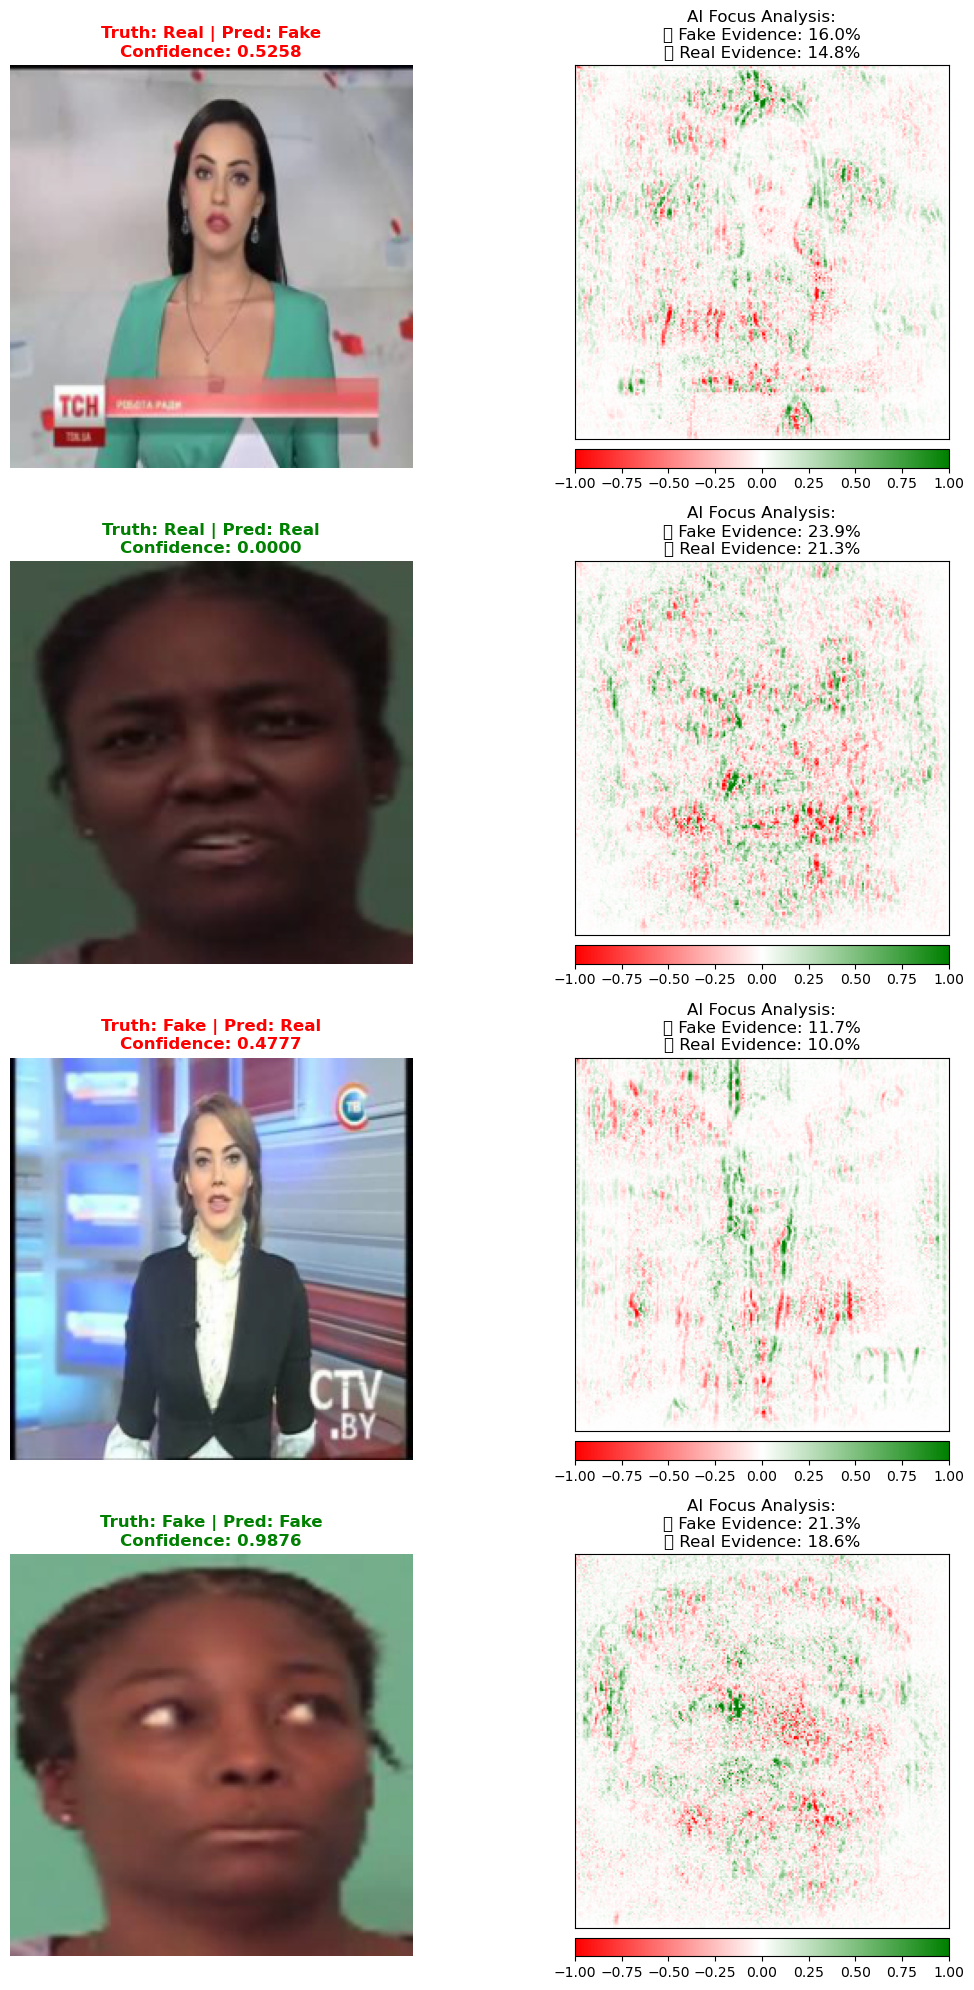

In [58]:
# --- Cell 13: Explainability with Percentages (Memory Safe Fix) ---
from captum.attr import IntegratedGradients, NoiseTunnel, visualization as viz
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import gc

# 1. Clear Memory Before Starting
torch.cuda.empty_cache()
gc.collect()

# Constants
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

print("🔍 Generating Quantitative Saliency Maps (Memory Safe Mode)...")

# 2. Define Wrapper
class ModelWrapper(torch.nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, x): 
        out = self.m(x)
        return out.unsqueeze(-1) if out.dim()==1 else out

# 3. Setup Explainability
model.eval()
wrapped = ModelWrapper(model).to(DEVICE)
ig = IntegratedGradients(wrapped)
nt = NoiseTunnel(ig)

# 4. Pick Images
real_indices = [i for i, x in enumerate(test_dataset) if x[1] == 0]
fake_indices = [i for i, x in enumerate(test_dataset) if x[1] == 1]

if len(real_indices) >= 2 and len(fake_indices) >= 2:
    viz_indices = random.sample(real_indices, 2) + random.sample(fake_indices, 2)
else:
    viz_indices = random.sample(range(len(test_dataset)), 4)

fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, idx in enumerate(viz_indices):
    # Clear memory each loop to be safe
    torch.cuda.empty_cache()
    
    t_img, lbl = test_dataset[idx]
    inp = t_img.unsqueeze(0).to(DEVICE)
    
    # A. Get Prediction
    with torch.no_grad():
        out = model(inp)
        score = torch.sigmoid(out).item()
        pred_lbl = "Fake" if score > 0.5 else "Real"
    
    # B. Calculate Attribution (Memory Safe)
    # nt_samples_batch_size=1 tells it to process the 10 noise samples one by one
    # This keeps memory usage low!
    try:
        attr = nt.attribute(inp, 
                            nt_type='smoothgrad', 
                            nt_samples=10, 
                            nt_samples_batch_size=1,  # <--- THE FIX
                            target=0)
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"⚠️ GPU OOM on image {idx}. Skipping Saliency for this image.")
            torch.cuda.empty_cache()
            continue
        else:
            raise e
    
    # C. Calculate Percentages
    attr_map = attr.squeeze().cpu().detach().numpy()
    attr_combined = np.sum(attr_map, axis=0)
    
    total_pixels = attr_combined.size
    red_pixels = np.count_nonzero(attr_combined > 0.001)
    green_pixels = np.count_nonzero(attr_combined < -0.001)
    
    pct_red = (red_pixels / total_pixels) * 100
    pct_green = (green_pixels / total_pixels) * 100
    
    # D. Prepare Image
    orig = t_img.permute(1,2,0).cpu().numpy()
    orig = (orig * STD) + MEAN
    orig = np.clip(orig, 0, 1)
    
    # E. Prepare Heatmap
    attr_np = np.transpose(attr_map, (1,2,0))
    
    # --- PLOTTING ---
    truth_str = "Fake" if lbl.item() == 1 else "Real"
    color = "green" if truth_str == pred_lbl else "red"
    
    axes[i][0].imshow(orig)
    axes[i][0].set_title(f"Truth: {truth_str} | Pred: {pred_lbl}\nConfidence: {score:.4f}", color=color, fontweight='bold')
    axes[i][0].axis('off')
    
    viz.visualize_image_attr(attr_np, orig, method="heat_map", sign="all", 
                             show_colorbar=True, plt_fig_axis=(fig, axes[i][1]), 
                             use_pyplot=False)
    
    axes[i][1].set_title(f"AI Focus Analysis:\n🔴 Fake Evidence: {pct_red:.1f}%\n🟢 Real Evidence: {pct_green:.1f}%")

plt.tight_layout()
plt.show()

#  Base Resnet18 Model

#### Cell 14: Robustness & Benchmarking
#### Corruptions check and Ablation comparison.

In [17]:
# --- Cell 14.0: Baseline Training (Pretrained ResNet-Only) ---
print("⏳ STARTING BASELINE TRAINING (ResNet-Only) for Comparison...")

class ResNetBaseline(nn.Module):
    def __init__(self, out_dim=128):
        super().__init__()
        # Use Pretrained weights for fair comparison
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.net = resnet
        self.net.fc = nn.Identity()
        self.proj = nn.Linear(512, out_dim)
        
        nn.init.kaiming_normal_(self.proj.weight, nonlinearity='relu')
        if self.proj.bias is not None: nn.init.zeros_(self.proj.bias)

        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        feat = self.proj(self.net(x)) 
        return self.classifier(feat).squeeze(-1)

# Setup Baseline
model_baseline = ResNetBaseline(out_dim=128).to(DEVICE)
opt_baseline = optim.AdamW(model_baseline.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit_baseline = nn.BCEWithLogitsLoss()
scaler_bl = torch.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

# Training Loop
for epoch in range(1, EPOCHS + 1):
    model_baseline.train()
    for xb, yb in tqdm(train_loader, desc=f"Baseline Epoch {epoch}", leave=False):
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        opt_baseline.zero_grad(set_to_none=True)
        
        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE.type == "cuda")):
            out = model_baseline(xb)
            loss = crit_baseline(out, yb)
        
        scaler_bl.scale(loss).backward()
        scaler_bl.step(opt_baseline)
        scaler_bl.update()

print("✅ Baseline Training Complete.")

# Inference with TTA for Baseline too (Fairness)
print("🧪 Evaluating Baseline on Test Set...")
bl_preds, bl_trues = [], []
model_baseline.eval()

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Baseline Inference"):
        valid = (yb != -1)
        if not valid.any(): continue
        xb = xb[valid].to(DEVICE)
        
        with torch.amp.autocast(device_type='cuda', enabled=(DEVICE.type == "cuda")):
            out1 = model_baseline(xb)
            out2 = model_baseline(torch.flip(xb, [3])) # TTA
            avg_probs = (torch.sigmoid(out1) + torch.sigmoid(out2)) / 2
        
        probs = avg_probs.squeeze().cpu().numpy().tolist()
        if isinstance(probs, float): probs = [probs]
        
        bl_preds.extend(probs)
        bl_trues.extend(yb[valid].cpu().numpy().tolist())

# Metrics
bl_trues = np.array(bl_trues)
bl_probs = np.array(bl_preds)
bl_classes = (bl_probs > 0.5).astype(int)

bl_auc = roc_auc_score(bl_trues, bl_probs)
bl_ap  = average_precision_score(bl_trues, bl_probs)
bl_f1  = f1_score(bl_trues, bl_classes)
bl_acc = accuracy_score(bl_trues, bl_classes)

baseline_metrics = [bl_auc, bl_ap, bl_f1, bl_acc]

# Save for safety
torch.save(model_baseline.state_dict(), os.path.join(CKPT_DIR, "baseline_resnet_final.pth"))
print("💾 Baseline model saved to disk.")

print(f"\n--- Baseline Results ---")
print(f"AUC: {bl_auc:.4f} | AP: {bl_ap:.4f} | F1: {bl_f1:.4f} | Acc: {bl_acc:.4f}")


⏳ STARTING BASELINE TRAINING (ResNet-Only) for Comparison...


✅ Baseline Training Complete.
🧪 Evaluating Baseline on Test Set...


Baseline Inference: 100%|██████████| 625/625 [04:03<00:00,  2.57it/s]


💾 Baseline model saved to disk.

--- Baseline Results ---
AUC: 0.9922 | AP: 0.9922 | F1: 0.9372 | Acc: 0.9335


✅ Found CSV files in: /mnt/c/Users/Ranjit/OneDrive/Documents/Antigravity/LearningProjects/DeepfakeDetection/dataset/140K
📉 Evaluating BASELINE (ResNet) on Full 140k Dataset...
✅ Baseline Model Loaded.
🧪 Starting Baseline Inference on 140000 images...


Baseline 140k: 100%|██████████| 4375/4375 [51:35<00:00,  1.41it/s]



📊 FINAL RESULTS (140k External Set):
   Baseline (ResNet): AUC=0.9990 | Acc=97.96%
   Ours (Mamba):      AUC=0.9262 | Acc=84.51%


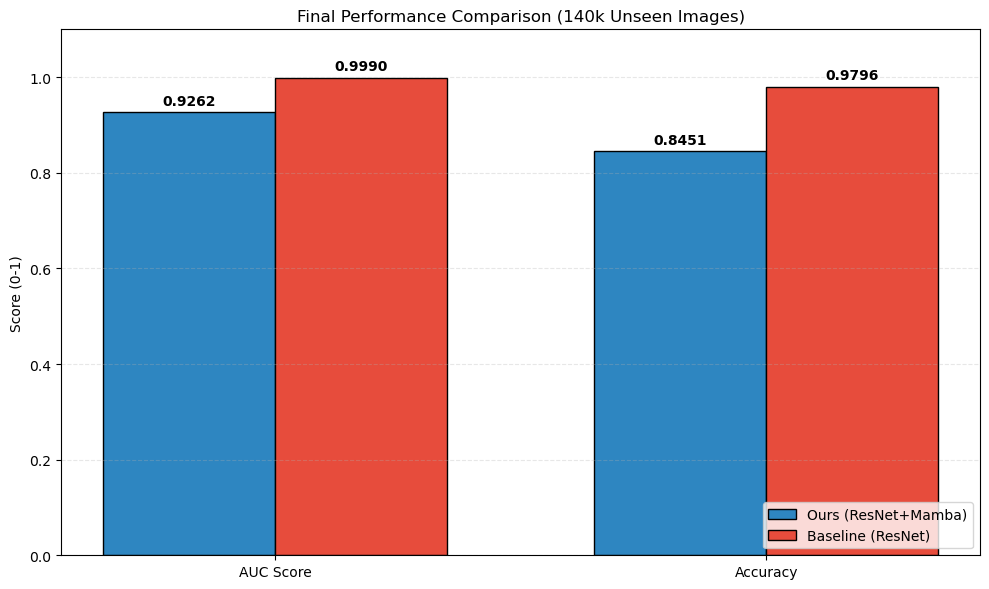

In [53]:
# --- Cell 14.1: Baseline vs. Mamba (Full 140k External Dataset) ---
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. SETUP: Intelligent Path Finding (Same as before)
search_paths = [EXT_DATA_ROOT, os.path.dirname(EXT_DATA_ROOT)]
found_root = None

for p in search_paths:
    if os.path.exists(os.path.join(p, 'train.csv')):
        found_root = p
        break

if found_root:
    print(f"✅ Found CSV files in: {found_root}")
    print("📉 Evaluating BASELINE (ResNet) on Full 140k Dataset...")

    # 2. Define Dataset Class
    class ExternalDataset(Dataset):
        def __init__(self, df, root, transform):
            self.df = df
            self.root = root
            self.transform = transform
            # Intelligent Path Logic
            first_path = self.df.iloc[0]['path']
            full_path = os.path.join(root, first_path)
            if not os.path.exists(full_path):
                alt_root = os.path.join(root, 'real_vs_fake')
                if os.path.exists(os.path.join(alt_root, first_path)):
                    self.root = alt_root 
            self.df['path'] = self.df['path'].apply(lambda x: os.path.join(self.root, x))
            
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            path = self.df.iloc[idx]['path']
            lbl = self.df.iloc[idx]['label']
            try:
                img = Image.open(path).convert('RGB')
                if self.transform: img = self.transform(img)
                return img, torch.tensor(lbl, dtype=torch.float32)
            except:
                return torch.zeros((3,224,224)), torch.tensor(-1.0)

    # 3. MERGE CSVs & LOAD BASELINE
    dfs = []
    for filename in ['test.csv', 'valid.csv', 'train.csv']:
        fp = os.path.join(found_root, filename)
        if os.path.exists(fp): dfs.append(pd.read_csv(fp))

    if dfs:
        full_df = pd.concat(dfs, ignore_index=True)
        ext_dataset = ExternalDataset(full_df, found_root, val_transform)
        ext_loader = DataLoader(ext_dataset, batch_size=32, shuffle=False, num_workers=2)

        # Load Baseline Model
        # (Re-defining class briefly to ensure it loads)
        from torchvision import models
        import torch.nn as nn
        class ResNetBaseline(nn.Module):
            def __init__(self, out_dim=128):
                super().__init__()
                self.net = models.resnet18(weights=None)
                self.net.fc = nn.Identity()
                self.proj = nn.Linear(512, out_dim)
                self.classifier = nn.Sequential(nn.Linear(out_dim, 64), nn.ReLU(), nn.Dropout(0.3), nn.Linear(64, 1))
            def forward(self, x):
                return self.classifier(self.proj(self.net(x))).squeeze(-1)

        model_baseline = ResNetBaseline(out_dim=128).to(DEVICE)
        bl_path = os.path.join(CKPT_DIR, "baseline_resnet_final.pth")
        if os.path.exists(bl_path):
            model_baseline.load_state_dict(torch.load(bl_path, map_location=DEVICE))
            model_baseline.eval()
            print("✅ Baseline Model Loaded.")
        else:
            print("⚠️ Baseline weights not found! Results will be random.")

        # 4. INFERENCE LOOP
        bl_preds, bl_trues = [], []
        print(f"🧪 Starting Baseline Inference on {len(full_df)} images...")
        
        with torch.no_grad():
            for imgs, lbls in tqdm(ext_loader, desc="Baseline 140k"):
                valid = (lbls != -1)
                if not valid.any(): continue
                imgs = imgs[valid].to(DEVICE)
                
                # Forward (No AMP)
                out = model_baseline(imgs)
                probs = torch.sigmoid(out).cpu().numpy().tolist()
                bl_preds.extend(probs if isinstance(probs, list) else [probs])
                bl_trues.extend(lbls[valid].numpy().tolist())

        # 5. METRICS & COMPARISON
        bl_trues = np.array(bl_trues)
        bl_probs = np.array(bl_preds)
        bl_auc = roc_auc_score(bl_trues, bl_probs)
        bl_acc = accuracy_score(bl_trues, (bl_probs > 0.5).astype(int))

        print(f"\n📊 FINAL RESULTS (140k External Set):")
        print(f"   Baseline (ResNet): AUC={bl_auc:.4f} | Acc={bl_acc*100:.2f}%")
        
        # Retrieve Mamba stats
        mamba_auc = ext_auc if 'ext_auc' in globals() else 0.0
        mamba_acc = ext_acc if 'ext_acc' in globals() else 0.0
        print(f"   Ours (Mamba):      AUC={mamba_auc:.4f} | Acc={mamba_acc*100:.2f}%")

        # 6. PLOT COMPARISON
        labels = ['AUC Score', 'Accuracy']
        mamba_scores = [mamba_auc, mamba_acc]
        baseline_scores = [bl_auc, bl_acc]

        x = np.arange(len(labels))
        width = 0.35

        plt.figure(figsize=(10, 6))
        rects1 = plt.bar(x - width/2, mamba_scores, width, label='Ours (ResNet+Mamba)', color='#2E86C1', edgecolor='black')
        rects2 = plt.bar(x + width/2, baseline_scores, width, label='Baseline (ResNet)', color='#E74C3C', edgecolor='black')

        plt.ylabel('Score (0-1)')
        plt.title('Final Performance Comparison (140k Unseen Images)')
        plt.xticks(x, labels)
        plt.legend(loc='lower right')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        # Add labels
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                plt.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                        f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()

    else:
        print("❌ No CSV files found.")
else:
    print("⚠️ Path configuration error.")

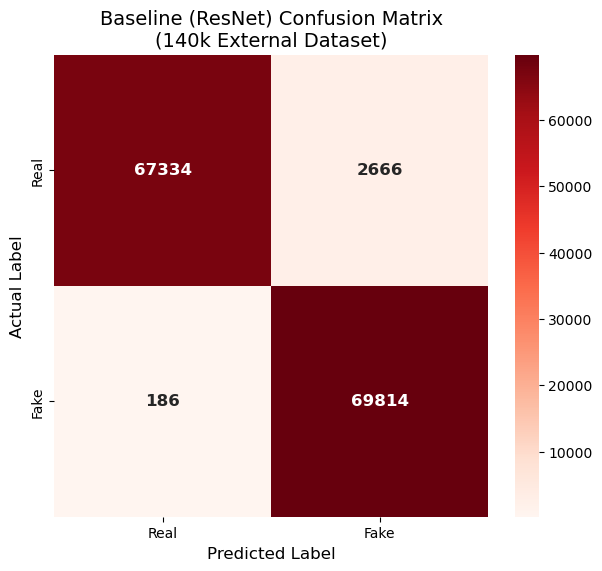

📊 BASELINE MATRIX BREAKDOWN:
   - True Negatives (Real correctly identified): 67334
   - False Positives (Real wrongly flagged as Fake): 2666
   - False Negatives (Fake wrongly trusted as Real): 186
   - True Positives (Fake correctly identified): 69814


In [55]:
# --- Cell 14.2: Baseline Confusion Matrix Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Safety Check: Ensure Baseline predictions exist from the previous cell
if 'bl_trues' in globals() and 'bl_preds' in globals() and len(bl_trues) > 0:
    
    # 2. Convert Probabilities to Class Predictions (Threshold = 0.5)
    # bl_preds is a list of floats, so we convert to numpy array first
    bl_probs_np = np.array(bl_preds)
    bl_classes = (bl_probs_np > 0.5).astype(int)
    
    # 3. Compute Confusion Matrix
    cm_bl = confusion_matrix(bl_trues, bl_classes)
    
    # 4. Plotting
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_bl, annot=True, fmt='d', cmap='Reds', # Red theme for Baseline
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'],
                annot_kws={"size": 12, "weight": "bold"})
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    plt.title(f'Baseline (ResNet) Confusion Matrix\n(140k External Dataset)', fontsize=14)
    plt.show()
    
    # 5. Print Text Summary
    tn, fp, fn, tp = cm_bl.ravel()
    print(f"📊 BASELINE MATRIX BREAKDOWN:")
    print(f"   - True Negatives (Real correctly identified): {tn}")
    print(f"   - False Positives (Real wrongly flagged as Fake): {fp}")
    print(f"   - False Negatives (Fake wrongly trusted as Real): {fn}")
    print(f"   - True Positives (Fake correctly identified): {tp}")

else:
    print("⚠️ Error: Baseline predictions (bl_trues/bl_preds) not found. Please run Cell 14.1 first.")

🕵️ INSPECTING BASELINE FOCUS (CPU Mode)...
⏳ Moving model to CPU for safe visualization...
   -> Processing image 1/4 on CPU...
   -> Processing image 2/4 on CPU...
   -> Processing image 3/4 on CPU...
   -> Processing image 4/4 on CPU...


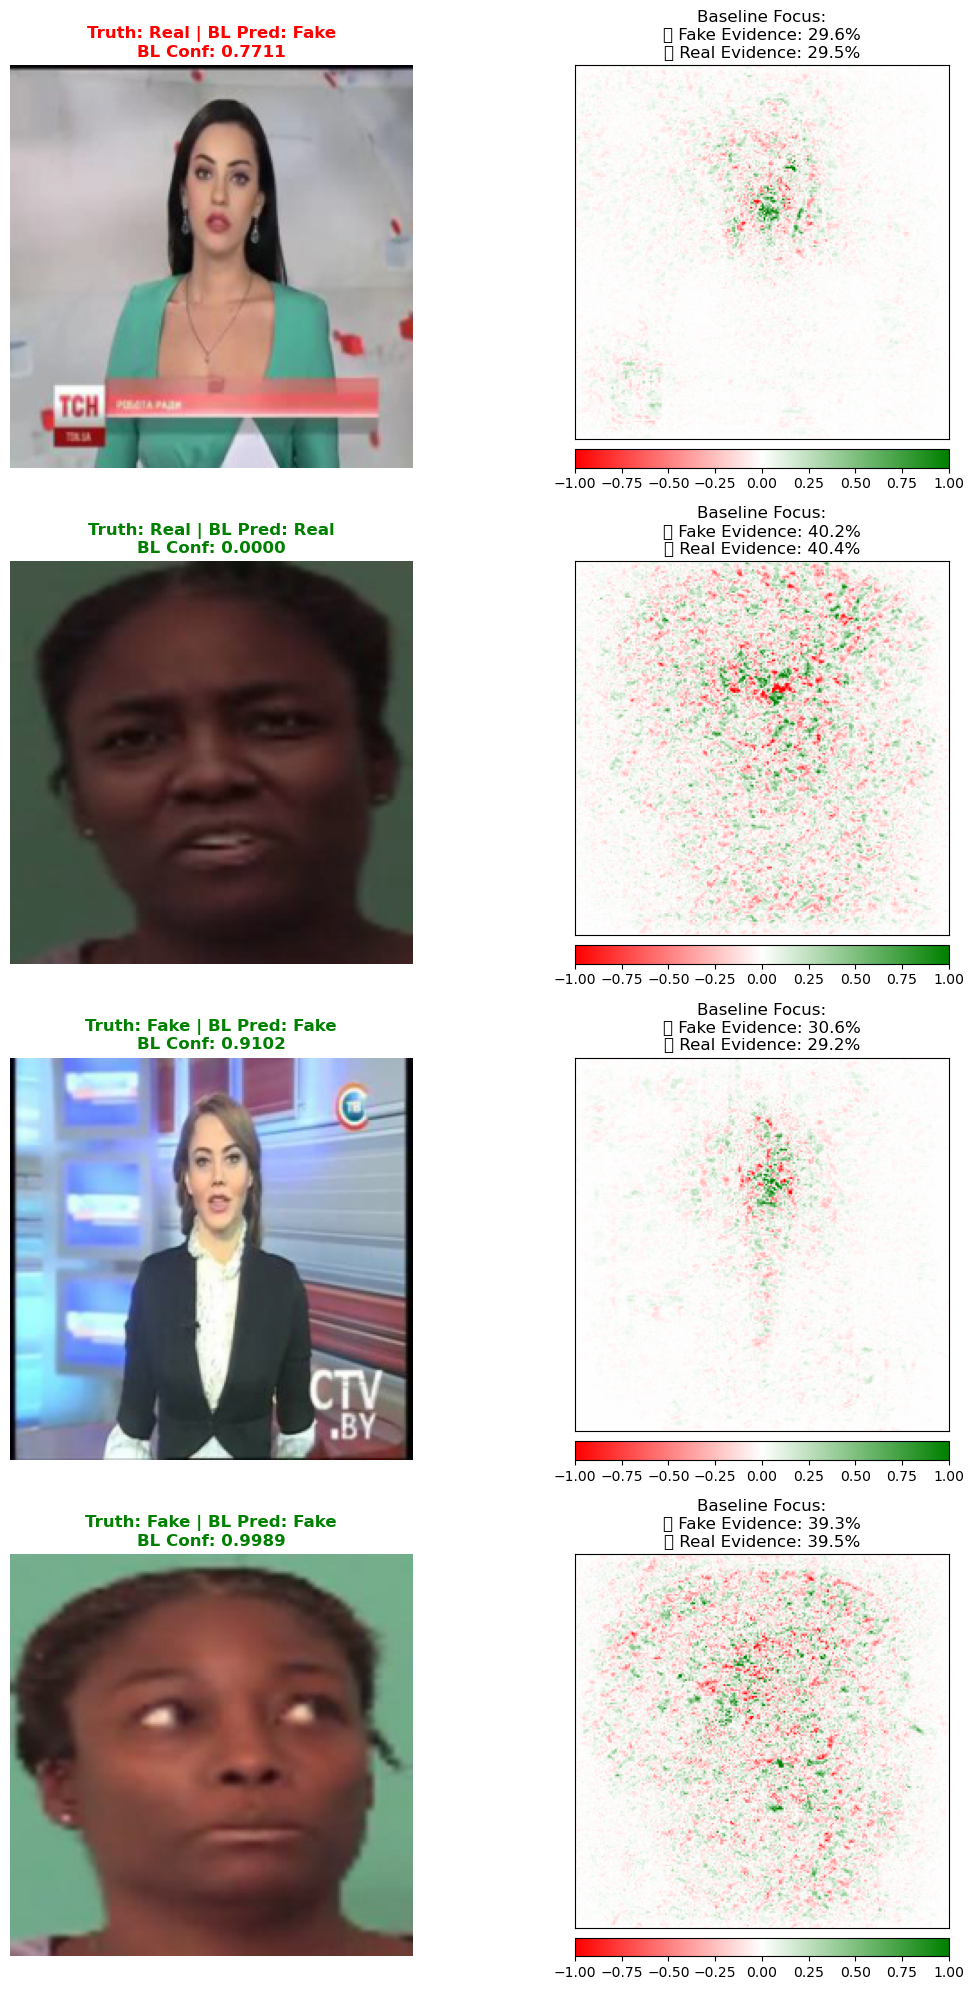

✅ Visualization Complete. Model moved back to GPU.


In [59]:
# --- Cell 15: Baseline Inspector (CPU Safe Mode) ---
from captum.attr import IntegratedGradients, NoiseTunnel, visualization as viz
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import gc

print("🕵️ INSPECTING BASELINE FOCUS (CPU Mode)...")

# 1. Clear GPU Memory First
torch.cuda.empty_cache()
gc.collect()

# 2. Define Wrapper
class ModelWrapper(torch.nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, x): 
        out = self.m(x)
        return out.unsqueeze(-1) if out.dim()==1 else out

# 3. Setup Baseline Model for Inspection (ON CPU)
# We move the model to CPU to avoid VRAM limits
if 'model_baseline' not in globals():
    print("⚠️ Baseline model not found! Please run the baseline training cell first.")
else:
    print("⏳ Moving model to CPU for safe visualization...")
    model_baseline.cpu()  # <--- Move to CPU
    model_baseline.eval()
    
    wrapped_bl = ModelWrapper(model_baseline)
    ig_bl = IntegratedGradients(wrapped_bl)
    nt_bl = NoiseTunnel(ig_bl)

    # 4. Ensure we have images (Reuse indices if available)
    if 'viz_indices' not in globals():
        viz_indices = random.sample(range(len(test_dataset)), 4)

    # Constants
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(4, 2, figsize=(12, 20))

    for i, idx in enumerate(viz_indices):
        # Load image and move to CPU immediately
        t_img, lbl = test_dataset[idx]
        inp = t_img.unsqueeze(0).to('cpu')  # <--- Input on CPU
        
        # A. Get Baseline Prediction
        with torch.no_grad():
            out = model_baseline(inp)
            score = torch.sigmoid(out).item()
            pred_lbl = "Fake" if score > 0.5 else "Real"

        # B. Calculate Attribution
        # Now running on System RAM (usually 16GB+), so this won't crash
        print(f"   -> Processing image {i+1}/4 on CPU...")
        attr_bl = nt_bl.attribute(inp, 
                                  nt_type='smoothgrad', 
                                  nt_samples=5,      # We can keep quality high now
                                  target=0)
        
        # C. Calculate Percentages
        attr_map = attr_bl.squeeze().detach().numpy()
        attr_combined = np.sum(attr_map, axis=0)
        
        total_pixels = attr_combined.size
        red_pixels = np.count_nonzero(attr_combined > 0.001) 
        green_pixels = np.count_nonzero(attr_combined < -0.001)
        
        pct_red = (red_pixels / total_pixels) * 100
        pct_green = (green_pixels / total_pixels) * 100
        
        # D. Prepare Image
        orig = t_img.permute(1,2,0).cpu().numpy()
        orig = (orig * STD) + MEAN
        orig = np.clip(orig, 0, 1)
        
        # E. Prepare Heatmap
        attr_np = np.transpose(attr_map, (1,2,0))
        
        # --- PLOTTING ---
        truth_str = "Fake" if lbl.item() == 1 else "Real"
        color = "green" if truth_str == pred_lbl else "red"
        
        axes[i][0].imshow(orig)
        axes[i][0].set_title(f"Truth: {truth_str} | BL Pred: {pred_lbl}\nBL Conf: {score:.4f}", color=color, fontweight='bold')
        axes[i][0].axis('off')
        
        viz.visualize_image_attr(attr_np, orig, method="heat_map", sign="all", 
                                 show_colorbar=True, plt_fig_axis=(fig, axes[i][1]), 
                                 use_pyplot=False)
        
        axes[i][1].set_title(f"Baseline Focus:\n🔴 Fake Evidence: {pct_red:.1f}%\n🟢 Real Evidence: {pct_green:.1f}%")

    plt.tight_layout()
    plt.show()

    # Move model back to GPU when done (optional)
    model_baseline.to(DEVICE)
    print("✅ Visualization Complete. Model moved back to GPU.")